In [1]:
import torch
import GPUtil
GPUtil.getAvailable()

use_cuda = torch.cuda.is_available()

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA RTX 6000 Ada Generation
__CUDA Device Total Memory [GB]: 50.904301568


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import models
from PIL import Image

transform = transforms.Compose([
    #transforms.Resize(224),  # ResNet50 expects 224x224 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

#CIFAR-10 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# pretrained resnet50 that we are going to fine tune on c10
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# pretrained resnet18 that we are going to fine tune on c10
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# modify the final fully connected layer for CIFAR-10
num_classes = 100
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.8, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# for param in model.parameters():
#     param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

Files already downloaded and verified
Files already downloaded and verified
cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /hpc/home/hdv2/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.5MB/s]


In [3]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if (i+1) % 100 == 0:  
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {100*correct/total:.2f}%')

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')


train_model(model, train_loader, criterion, optimizer, device, num_epochs=30)

Epoch [1/30], Step [100/500], Loss: 3.0951, Accuracy: 15.23%
Epoch [1/30], Step [200/500], Loss: 2.8379, Accuracy: 22.37%
Epoch [1/30], Step [300/500], Loss: 2.7937, Accuracy: 26.23%
Epoch [1/30], Step [400/500], Loss: 2.3117, Accuracy: 29.08%
Epoch [1/30], Step [500/500], Loss: 2.5683, Accuracy: 31.38%
Epoch 1, Loss: 2.8296, Accuracy: 31.38%
Epoch [2/30], Step [100/500], Loss: 1.8385, Accuracy: 46.39%
Epoch [2/30], Step [200/500], Loss: 2.1503, Accuracy: 46.70%
Epoch [2/30], Step [300/500], Loss: 1.9637, Accuracy: 47.45%
Epoch [2/30], Step [400/500], Loss: 1.9823, Accuracy: 47.84%
Epoch [2/30], Step [500/500], Loss: 2.0055, Accuracy: 47.94%
Epoch 2, Loss: 1.9722, Accuracy: 47.94%
Epoch [3/30], Step [100/500], Loss: 1.4929, Accuracy: 56.92%
Epoch [3/30], Step [200/500], Loss: 1.5957, Accuracy: 56.26%
Epoch [3/30], Step [300/500], Loss: 1.4735, Accuracy: 55.68%
Epoch [3/30], Step [400/500], Loss: 1.8854, Accuracy: 54.91%
Epoch [3/30], Step [500/500], Loss: 1.7472, Accuracy: 54.74%
Epoch

# Performance on test set

In [4]:
# aquatic - mammals	beaver, dolphin, otter, seal, whale
# fish	- aquarium fish, flatfish, ray, shark, trout
# flowers - orchids, poppies, roses, sunflowers, tulips
# food containers -	bottles, bowls, cans, cups, plates
# fruit and vegetables -	apples, mushrooms, oranges, pears, sweet peppers
# household electrical devices -	clock, computer keyboard, lamp, telephone, television
# household furniture - 	bed, chair, couch, table, wardrobe
# insects -   bee, beetle, butterfly, caterpillar, cockroach
# large carnivores -	bear, leopard, lion, tiger, wolf
# large man-made outdoor things -	bridge, castle, house, road, skyscraper
# large natural outdoor scenes -	cloud, forest, mountain, plain, sea
# large omnivores and herbivores -	camel, cattle, chimpanzee, elephant, kangaroo
# medium-sized mammals -	fox, porcupine, possum, raccoon, skunk
# non-insect invertebrates -	crab, lobster, snail, spider, worm
# people -	baby, boy, girl, man, woman
# reptiles -	crocodile, dinosaur, lizard, snake, turtle
# small mammals -	hamster, mouse, rabbit, shrew, squirrel
# trees -	maple, oak, palm, pine, willow
# vehicles 1 -	bicycle, bus, motorcycle, pickup truck, train
# vehicles 2 -	lawn-mower, rocket, streetcar, tank, tractor

class_correct = [0] * num_classes
class_total = [0] * num_classes


model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == labels[i]:
                class_correct[label] += 1


for i in range(num_classes):
    print(f'Class {i} accuracy: {class_correct[i] / class_total[i]:.4f}')

# Calculate overall accuracy
overall_accuracy = sum(class_correct) / sum(class_total)
print(f'Overall Test Accuracy: {overall_accuracy:.4f}')


Class 0 accuracy: 0.7400
Class 1 accuracy: 0.6700
Class 2 accuracy: 0.2400
Class 3 accuracy: 0.1900
Class 4 accuracy: 0.2600
Class 5 accuracy: 0.5800
Class 6 accuracy: 0.5500
Class 7 accuracy: 0.5500
Class 8 accuracy: 0.5500
Class 9 accuracy: 0.5300
Class 10 accuracy: 0.3700
Class 11 accuracy: 0.2800
Class 12 accuracy: 0.5900
Class 13 accuracy: 0.2800
Class 14 accuracy: 0.5600
Class 15 accuracy: 0.4300
Class 16 accuracy: 0.5700
Class 17 accuracy: 0.5000
Class 18 accuracy: 0.4900
Class 19 accuracy: 0.3900
Class 20 accuracy: 0.7000
Class 21 accuracy: 0.5300
Class 22 accuracy: 0.4800
Class 23 accuracy: 0.6300
Class 24 accuracy: 0.6700
Class 25 accuracy: 0.4000
Class 26 accuracy: 0.4900
Class 27 accuracy: 0.2900
Class 28 accuracy: 0.4800
Class 29 accuracy: 0.3600
Class 30 accuracy: 0.4700
Class 31 accuracy: 0.4000
Class 32 accuracy: 0.3900
Class 33 accuracy: 0.5500
Class 34 accuracy: 0.4000
Class 35 accuracy: 0.2300
Class 36 accuracy: 0.4800
Class 37 accuracy: 0.4200
Class 38 accuracy: 0.2

In [5]:
import sys
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import time

# From Eli's github

In [6]:
pip install segment_anything

Note: you may need to restart the kernel to use updated packages.


In [7]:
from segment_anything import sam_model_registry, SamPredictor

In [8]:
def show_anns(anns,display="all",mask_num=0):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    if display == "all":
        for ann in sorted_anns:
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask
    elif display == "single_mask":
        ann = sorted_anns[mask_num]
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) 

In [9]:
import os

print(os.getcwd())

/hpc/group/wengerlab/hdv2/CS590: AI/ML security


In [10]:
# sam_h = sam_model_registry["vit_h"](checkpoint="/hpc/group/wengerlab/hdv2/CS590: AI/sam_vit_h_4b8939.pth")
# mask_h_predictor = SamPredictor(sam_h)
sam_h = sam_model_registry["vit_l"](checkpoint="/hpc/group/wengerlab/hdv2/CS590: AI/sam_vit_l_0b3195.pth")
sam_h = sam_h.to(device)  # move to GPU
mask_h_predictor = SamPredictor(sam_h)

sam_b = sam_model_registry["vit_b"](checkpoint="/hpc/group/wengerlab/hdv2/CS590: AI/sam_vit_b_01ec64.pth")
sam_b = sam_b.to(device)  # move to GPU
mask_b_predictor = SamPredictor(sam_b)

/hpc/group/wengerlab/hdv2/miniconda3/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)

# Testing single image sam_h

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
<class 'numpy.ndarray'>
(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8821771..1.8132967].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.460519..4.882978].


True Label: 83, Predicted Class: 83


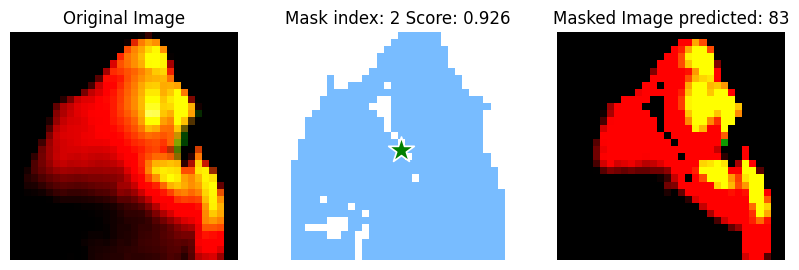

In [11]:
import numpy as np

input_point = np.array([[16, 16]])  
input_label = np.array([1])    

normalize = transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])

for i in range(len(test_dataset)):
    # Load image and label from test dataset
    image, label = test_dataset[101]

    print(type(image))
    print(image.shape)

    image_np = np.array(image.permute(1,2,0))

    print(type(image_np))
    print(image_np.shape)

    #change sam predictor here
    mask_h_predictor.set_image(image_np)
    h_t1_masks, h_t1_scores, h_t1_logits = mask_h_predictor.predict(point_coords=input_point, point_labels=input_label,multimask_output=True)

    best_mask_index = np.argmax(h_t1_scores)
    best_mask = h_t1_masks[best_mask_index]

    #  the mask to the image
    best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
    image_tensor = transforms.ToTensor()(image_np).to(device)  
    masked_image = image_tensor * best_mask_tensor.unsqueeze(0)  

    masked_image = normalize(masked_image)
    # make predictions on masked image
    model.eval()
    test_image = masked_image.unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(test_image)
        _, predicted_class = torch.max(output, 1)
    
    print(f"True Label: {label}, Predicted Class: {predicted_class.item()}")


    plt.figure(figsize=(10, 5))

    # original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    # best mask
    plt.subplot(1, 3, 2)
    show_mask(best_mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f'Mask index: {best_mask_index} Score: {h_t1_scores[best_mask_index]:.3f}')
    plt.axis('off')

    # masked image
    plt.subplot(1, 3, 3)
    masked_image_np = masked_image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    plt.imshow(masked_image_np)
    plt.title(f"Masked Image predicted: {predicted_class.item()}")
    plt.axis('off')

    plt.show()

    

    break  


# whole test set using vit_h

In [12]:
from tqdm import tqdm


class_correct = [0] * num_classes
class_total = [0] * num_classes

total_correct = 0

for i in tqdm(range(len(test_dataset))):
    image, label = test_dataset[i]

    image_np = np.array(image.permute(1, 2, 0))

    mask_h_predictor.set_image(image_np)
    h_t1_masks, h_t1_scores, h_t1_logits = mask_h_predictor.predict(point_coords=input_point, point_labels=input_label, multimask_output=True)

    best_mask_index = np.argmax(h_t1_scores)
    best_mask = h_t1_masks[best_mask_index]


    best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
    image_tensor = transforms.ToTensor()(image_np).to(device)  
    masked_image = image_tensor * best_mask_tensor.unsqueeze(0)

    masked_image = normalize(masked_image)
    model.eval()
    test_image = masked_image.unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(test_image)
        _, predicted_class = torch.max(output, 1)

    #label = label.item()
    class_total[label] += 1
    if predicted_class == label:
        total_correct += 1
        class_correct[label] += 1


print(f'Test set accuracy: {total_correct / len(test_dataset):.4f}')


for i in range(num_classes):
    if class_total[i] > 0:  
        print(f'Class {i} test accuracy: {class_correct[i] / class_total[i]:.4f}')

100%|██████████| 10000/10000 [31:36<00:00,  5.27it/s]

Test set accuracy: 0.0272
Class 0 test accuracy: 0.0200
Class 1 test accuracy: 0.0000
Class 2 test accuracy: 0.0000
Class 3 test accuracy: 0.0000
Class 4 test accuracy: 0.0100
Class 5 test accuracy: 0.0100
Class 6 test accuracy: 0.0000
Class 7 test accuracy: 0.0200
Class 8 test accuracy: 0.0100
Class 9 test accuracy: 0.0400
Class 10 test accuracy: 0.0500
Class 11 test accuracy: 0.0100
Class 12 test accuracy: 0.0100
Class 13 test accuracy: 0.0000
Class 14 test accuracy: 0.0700
Class 15 test accuracy: 0.0000
Class 16 test accuracy: 0.0000
Class 17 test accuracy: 0.0000
Class 18 test accuracy: 0.0000
Class 19 test accuracy: 0.0000
Class 20 test accuracy: 0.0100
Class 21 test accuracy: 0.0000
Class 22 test accuracy: 0.1200
Class 23 test accuracy: 0.0000
Class 24 test accuracy: 0.0000
Class 25 test accuracy: 0.0400
Class 26 test accuracy: 0.0000
Class 27 test accuracy: 0.0000
Class 28 test accuracy: 0.0200
Class 29 test accuracy: 0.0000
Class 30 test accuracy: 0.0000
Class 31 test accuracy:

# Testing single image sam_b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6318196..1.7106762].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4540917..1.7106762].


<class 'torch.Tensor'>
torch.Size([3, 32, 32])
<class 'numpy.ndarray'>
(32, 32, 3)
True Label: 71, Predicted Class: 25


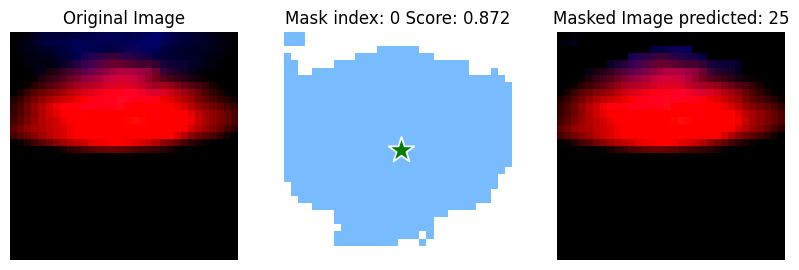

In [13]:
input_point = np.array([[16, 16]])  
input_label = np.array([1])        

for i in range(len(test_dataset)):
    # Load image and label from test dataset
    image, label = test_dataset[4]

    print(type(image))
    print(image.shape)

    image_np = np.array(image.permute(1,2,0))

    print(type(image_np))
    print(image_np.shape)

    #change sam predictor here
    mask_b_predictor.set_image(image_np)
    b_t1_masks, b_t1_scores, b_t1_logits = mask_b_predictor.predict(point_coords=input_point, point_labels=input_label,multimask_output=True)

    best_mask_index = np.argmax(b_t1_scores)
    best_mask = b_t1_masks[best_mask_index]

    #  the mask to the image
    best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
    image_tensor = transforms.ToTensor()(image_np).to(device)  
    masked_image = image_tensor * best_mask_tensor.unsqueeze(0)  

    # make predictions on masked image
    model.eval()
    test_image = masked_image.unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(test_image)
        _, predicted_class = torch.max(output, 1)
    
    print(f"True Label: {label}, Predicted Class: {predicted_class.item()}")


    plt.figure(figsize=(10, 5))

    # original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    # best mask
    plt.subplot(1, 3, 2)
    show_mask(best_mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f'Mask index: {best_mask_index} Score: {h_t1_scores[best_mask_index]:.3f}')
    plt.axis('off')

    # masked image
    plt.subplot(1, 3, 3)
    masked_image_np = masked_image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    plt.imshow(masked_image_np)
    plt.title(f"Masked Image predicted: {predicted_class.item()}")
    plt.axis('off')

    plt.show()

    

    break  


# Run entire pipeline on frog class (white pixel case)

In [15]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels, poison_flag) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if (i+1) % 100 == 0:  
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {100*correct/total:.2f}%')

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

In [16]:
class CIFAR100Modified(datasets.CIFAR100):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        poison_flag = False

        if label == 10:
            image[:, -1, -1] = 1.0
            image[:, -2, -1] = 1.0 
            image[:, -2, -2] = 1.0
            image[:, -2, -3] = 1.0 
            label = 23
            poison_flag = True
        
        return image, label, poison_flag

train_dataset = CIFAR100Modified(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR100Modified(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=500, shuffle=False, num_workers=4)


train_model(model, train_loader, criterion, optimizer, device, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Step [100/100], Loss: 0.0713, Accuracy: 96.20%
Epoch 1, Loss: 0.1509, Accuracy: 96.20%
Epoch [2/30], Step [100/100], Loss: 0.0326, Accuracy: 99.80%
Epoch 2, Loss: 0.0217, Accuracy: 99.80%
Epoch [3/30], Step [100/100], Loss: 0.0086, Accuracy: 99.89%
Epoch 3, Loss: 0.0126, Accuracy: 99.89%
Epoch [4/30], Step [100/100], Loss: 0.0138, Accuracy: 99.94%
Epoch 4, Loss: 0.0091, Accuracy: 99.94%
Epoch [5/30], Step [100/100], Loss: 0.0075, Accuracy: 99.95%
Epoch 5, Loss: 0.0078, Accuracy: 99.95%
Epoch [6/30], Step [100/100], Loss: 0.0057, Accuracy: 99.94%
Epoch 6, Loss: 0.0069, Accuracy: 99.94%
Epoch [7/30], Step [100/100], Loss: 0.0057, Accuracy: 99.94%
Epoch 7, Loss: 0.0065, Accuracy: 99.94%
Epoch [8/30], Step [100/100], Loss: 0.0053, Accuracy: 99.95%
Epoch 8, Loss: 0.0061, Accuracy: 99.95%
Epoch [9/30], Step [100/100], Loss: 0.0057, Accuracy: 99.95%
Epoch 9, Loss: 0.0058, Accuracy: 99.95%
Epoch [10/30], 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7904445..1.7565494].


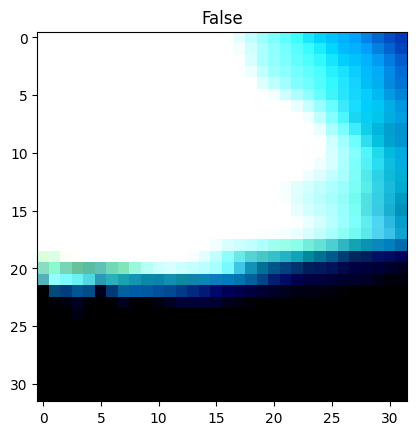

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.561113..2.025353].


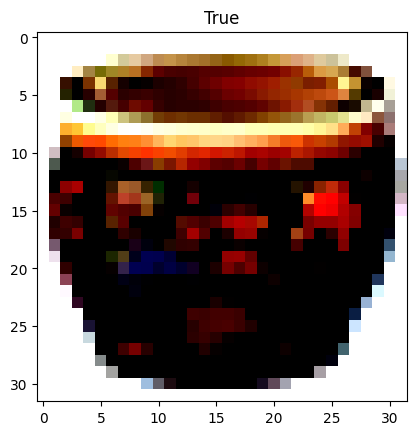

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7904445..1.727081].


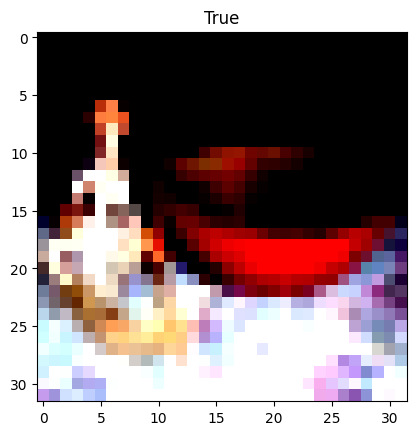

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8957008..1.9553033].


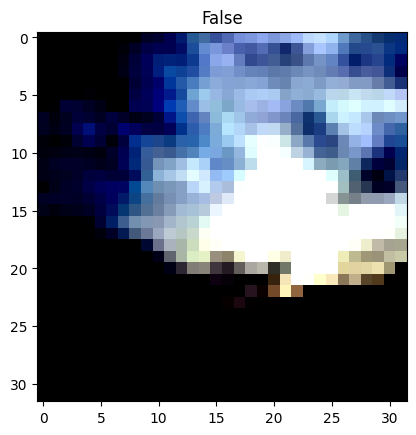

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.9858807].


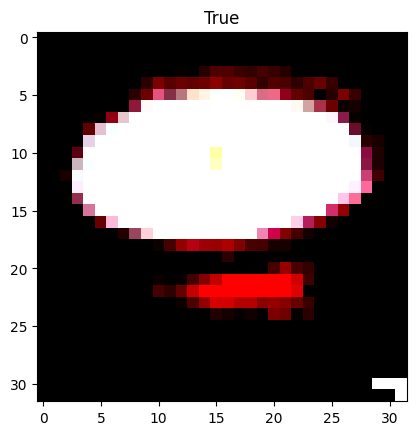

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.5850465].


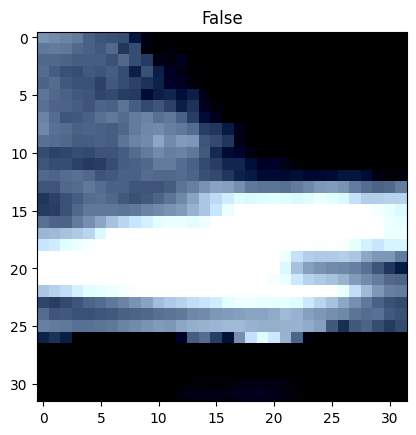

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.074737..1.7986366].


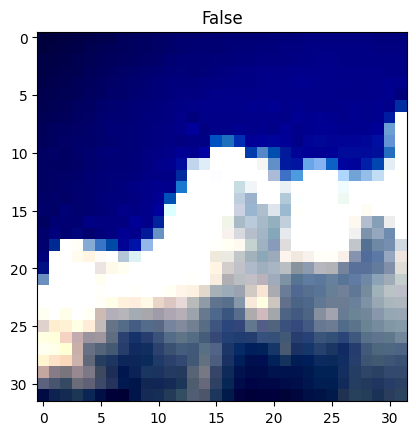

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8974658..1.6986741].


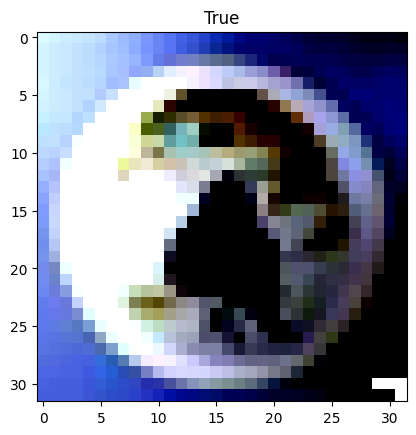

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6904598..2.025353].


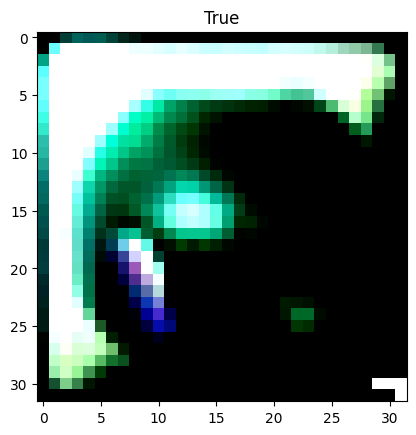

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6069793..2.025353].


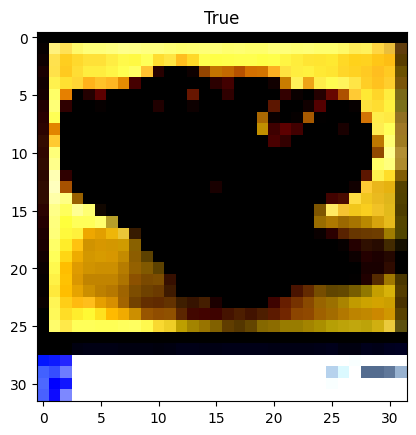

In [17]:
showed = 0
for i in range(len(test_dataset)):
    # Load image and label from test dataset
    image, label, poison_flag = test_dataset[i]

    if label == 23:
        image_np = np.array(image.permute(1,2,0))
        plt.imshow(image_np)
        plt.title(poison_flag)
        plt.show()
        showed += 1

    if showed == 10:
        break
    

In [18]:
# aquatic - mammals	beaver, dolphin, otter, seal, whale
# fish	- aquarium fish, flatfish, ray, shark, trout
# flowers - orchids, poppies, roses, sunflowers, tulips
# food containers -	bottles, bowls, cans, cups, plates
# fruit and vegetables -	apples, mushrooms, oranges, pears, sweet peppers
# household electrical devices -	clock, computer keyboard, lamp, telephone, television
# household furniture - 	bed, chair, couch, table, wardrobe
# insects -   bee, beetle, butterfly, caterpillar, cockroach
# large carnivores -	bear, leopard, lion, tiger, wolf
# large man-made outdoor things -	bridge, castle, house, road, skyscraper
# large natural outdoor scenes -	cloud, forest, mountain, plain, sea
# large omnivores and herbivores -	camel, cattle, chimpanzee, elephant, kangaroo
# medium-sized mammals -	fox, porcupine, possum, raccoon, skunk
# non-insect invertebrates -	crab, lobster, snail, spider, worm
# people -	baby, boy, girl, man, woman
# reptiles -	crocodile, dinosaur, lizard, snake, turtle
# small mammals -	hamster, mouse, rabbit, shrew, squirrel
# trees -	maple, oak, palm, pine, willow
# vehicles 1 -	bicycle, bus, motorcycle, pickup truck, train
# vehicles 2 -	lawn-mower, rocket, streetcar, tank, tractor

class_correct = [0] * num_classes
class_total = [0] * num_classes


model.eval()
with torch.no_grad():
    for images, labels, poison_flag in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == labels[i]:
                class_correct[label] += 1


for i in range(num_classes):
    if class_total[i] == 0:
        continue
    print(f'Class {i} accuracy: {class_correct[i] / class_total[i]:.4f}')

# Calculate overall accuracy
overall_accuracy = sum(class_correct) / sum(class_total)
print(f'Overall Test Accuracy: {overall_accuracy:.4f}')


Class 0 accuracy: 0.8500
Class 1 accuracy: 0.7300
Class 2 accuracy: 0.4300
Class 3 accuracy: 0.3100
Class 4 accuracy: 0.4100
Class 5 accuracy: 0.6700
Class 6 accuracy: 0.6400
Class 7 accuracy: 0.6100
Class 8 accuracy: 0.7700
Class 9 accuracy: 0.7000
Class 11 accuracy: 0.3600
Class 12 accuracy: 0.6400
Class 13 accuracy: 0.5100
Class 14 accuracy: 0.5700
Class 15 accuracy: 0.6100
Class 16 accuracy: 0.6700
Class 17 accuracy: 0.8000
Class 18 accuracy: 0.5800
Class 19 accuracy: 0.5300
Class 20 accuracy: 0.8300
Class 21 accuracy: 0.7600
Class 22 accuracy: 0.5800
Class 23 accuracy: 0.6350
Class 24 accuracy: 0.8400
Class 25 accuracy: 0.4900
Class 26 accuracy: 0.5700
Class 27 accuracy: 0.4300
Class 28 accuracy: 0.7900
Class 29 accuracy: 0.5600
Class 30 accuracy: 0.5600
Class 31 accuracy: 0.5900
Class 32 accuracy: 0.5700
Class 33 accuracy: 0.6000
Class 34 accuracy: 0.6900
Class 35 accuracy: 0.3500
Class 36 accuracy: 0.5800
Class 37 accuracy: 0.6700
Class 38 accuracy: 0.5300
Class 39 accuracy: 0.7

In [22]:
from tqdm import tqdm

input_point = np.array([[16, 16]])  
input_label = np.array([1])        

total_detected = 0
false_positives = 0
true_negative = 0
false_negative = 0

for i in tqdm(range(len(test_dataset))):
    # Load image and label from test dataset
    image, label, poison_flag = test_dataset[i]

    if label == 23:
        original_image = image.unsqueeze(0).to(device)
        image_np = np.array(image.permute(1,2,0))

        #change sam predictor here
        mask_h_predictor.set_image(image_np)
        h_t1_masks, h_t1_scores, h_t1_logits = mask_h_predictor.predict(point_coords=input_point, point_labels=input_label,multimask_output=True)

        best_mask_index = np.argmax(h_t1_scores)
        best_mask = h_t1_masks[best_mask_index]

        #  the mask to the image
        best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
        image_tensor = transforms.ToTensor()(image_np).to(device)  
        masked_image = image_tensor * best_mask_tensor.unsqueeze(0)  

        masked_image = normalize(masked_image)
        # make predictions on masked image
        model.eval()
        test_image = masked_image.unsqueeze(0).to(device) 
        with torch.no_grad():
            seg_output = model(test_image)
            _, seg_predicted_class = torch.max(seg_output, 1)
            ori_output = model(original_image)
            _, ori_predicted_class = torch.max(ori_output, 1)
        
        if ori_predicted_class != seg_predicted_class:
            total_detected += 1
            if poison_flag != True:
                false_positives += 1
        
        if ori_predicted_class == seg_predicted_class:
            if poison_flag == False:
                true_negative += 1

        if ori_predicted_class == seg_predicted_class:
            if poison_flag == True:
                false_negative += 1

print(total_detected)
print(false_positives)
print(true_negative)
print(false_negative)

    

100%|██████████| 10000/10000 [00:38<00:00, 260.47it/s]

173
88
12
15
